In [21]:
library(astsa)
library(forecast)
library(FitAR)
library(Metrics)

df <- read.csv("projectdata_covid.csv")
head(df)

,Date,New.Cases
,<fct>,<int>
1,6/20/20,704
2,6/21/20,579
3,6/22/20,870
4,6/23/20,872
5,6/24/20,747
6,6/25/20,682


# 1 Executive Summary
The COVID-19 pandemic, caused by SARS-CoV-2, presents an unprecedented and global healthcare challenge. Forecast models for new cases are essential to develop effective healthcare plans for mitigating the spread of the virus. In this report, we model the emergence of COVID-19 cases in Gotham City from 6/20/2020 to 8/18/2020 and predict values for 8/19/2020 to 8/28/2020. From our parametric model with SARMA(0,1)[14] noise, new cases of COVID-19 will continue to increase over the next ten days, reaching a historical high of ~1700 cases on 8/24/2020. 

# 2 Exploratory Data Analysis

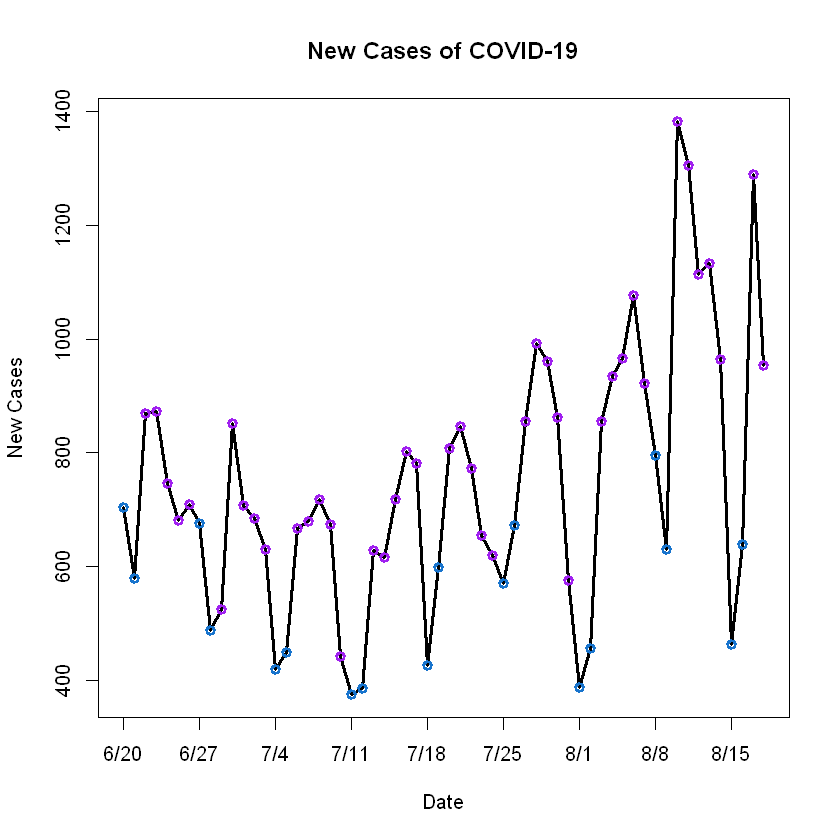

In [20]:
# plot new cases
plot.ts(df$New.Cases, type = "o", lwd = 2.5, 
        xaxt = "n", xlab = "Date", ylab = "New Cases", main = "New Cases of COVID-19")
time <- c(1:length(df$New.Cases))

#Day of week and month of year values
df$DoW <- weekdays(as.Date(df$Date, tryFormats = "%m/%d/%Y")) # weekdays() extracts the DoW from a Date value
df$MoY <- months(as.Date(df$Date, tryFormats = "%m/%d/%Y")) # months() extracts MoY from a Date value

#labels for the xaxis
xLabel <- c("6/20", "6/27", "7/4", "7/11", "7/18", "7/25", "8/1", "8/8", "8/15") 
axis(side = 1, at = seq(1,60, by = 7), labels = xLabel) # replace numerical labels with date labels

#color weekday values purple and weekend values blue
points(which(df$DoW == "Monday"), df$New.Cases[df$DoW == "Monday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Tuesday"), df$New.Cases[df$DoW == "Tuesday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Wednesday"), df$New.Cases[df$DoW == "Wednesday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Thursday"), df$New.Cases[df$DoW == "Thursday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Friday"), df$New.Cases[df$DoW == "Friday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Saturday"), df$New.Cases[df$DoW == "Saturday"], 
       col = "dodgerblue3", lwd = 2.5)
points(which(df$DoW == "Sunday"), df$New.Cases[df$DoW == "Sunday"], 
       col = "dodgerblue3", lwd = 2.5)

New cases for COVID-19 (henceforce referred to as "cases") exhibit a quadratically increasing trend with weekly periodicity. Cases peak during the working week (see the purple marks in Figure 1) and troph during the weekends (see blue marks in Figure 1). Also of note is the increasing weekly variance of cases. 

# 3   Models Considered

We assume that the time series of new cases consists of the sum of a signal component and a noise component. We adress the signal component of the data using both parametric (Section 3.1) and differencing (Section 3.2) approaches. The goal of both approaches is to have stationary residuals which can then be described with ARMA models (Sections 3.1.1, 3.1.2, 3.2.1, and 3.2.2).

## 3.1   Model 1: Parametric Signal Model   
We first consider a parametric signal model. The parametric model incorporates a polynomial that changes behavior with the seven days of the week. To do this, indicators for the seven days of the week are interacted with a quadratic function of time. The spectral density of the resulting residuals had an anomylous peak at the period of 12 days. As such, we incorporate a sinusoid that increases depending on the day of the week by interacting a sinusoid ($f=1/12$) with indicators for the seven days of the week. Finally, monthly indicators are added to complete the model. This parametric signal model (henceforth, Model 1) is detailed in Equation 1 where $X_t$ is the additive stationary noise term. 


\begin{align}
\text{Cases}_t &= \beta_0 + \beta_1t +\beta_2t^2 +
\sum_{j=1}^6 \left[  (\beta_{3j}+\beta_{3j+1} t+\beta_{3j+2} t^2) I_{\text{weekday}_{jt}} \right] +
\beta_{21} \cos \left(\frac{2\pi t}{12} \right) + 
\beta_{22} \sin \left(\frac{2\pi t}{12} \right) \notag \\
&+ \sum_{j=1}^6 \left[ \left(\beta_{2j+21} \cos \left(\frac{2\pi t}{12} \right) + \beta_{2j+22} \sin \left(\frac{2\pi t}{12} \right)\right) I_{\text{weekday}_{jt}} \right] + \beta_{35} I_{\text{June}_t} + \beta_{36} I_{\text{July}_t} + X_t. 
\end{align}

Figure 2 shows the fit of Model 1 as well as the residuals which appear reasonably stationary. 